# Dataset Preparation

## Imports

In [4]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchaudio.transforms import MelSpectrogram, FrequencyMasking
import librosa
import cv2
from pathlib import Path
from tqdm import tqdm
import os
from os import listdir, scandir

## Helper functions

In [5]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

## Start preparing dataset

In [6]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,../data/59/7_59_29.wav,7
1,../data/59/7_59_15.wav,7
2,../data/59/2_59_1.wav,2
3,../data/59/3_59_1.wav,3
4,../data/59/9_59_22.wav,9
...,...,...
29995,../data/25/5_25_27.wav,5
29996,../data/25/5_25_33.wav,5
29997,../data/25/7_25_2.wav,7
29998,../data/25/6_25_2.wav,6


In [7]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


## Start creating dataset 

In [8]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

sample.shape: torch.Size([1, 24, 48]), sample.class: 6


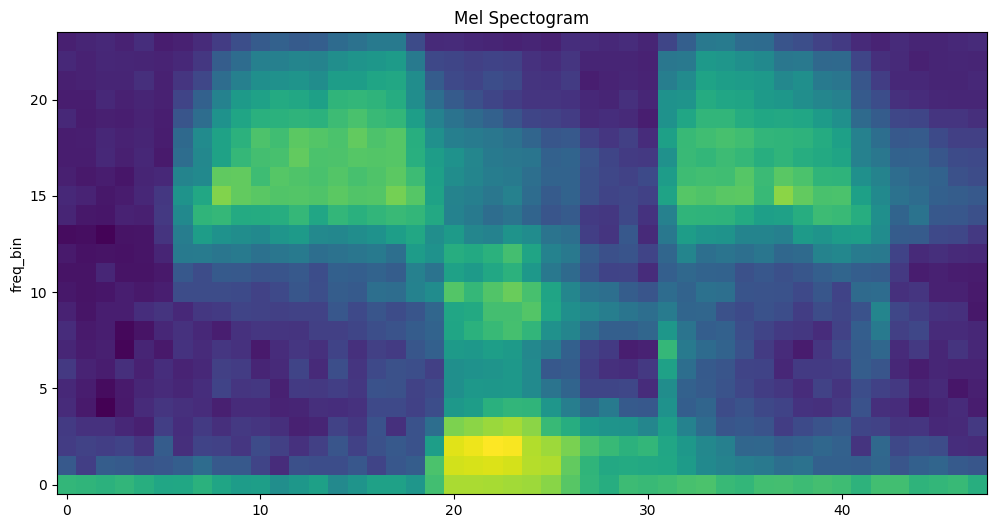

In [9]:
class RawAudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        return specgram, class_label, path_to_audio

    def __len__(self):
        return self.df.shape[0]

ds = RawAudioDataset(audio_df, transform)
sample = ds[29999]
plot_spectogram(sample[0][0], 'Mel Spectogram')
print(f'sample.shape: {sample[0].shape}, sample.class: {sample[1]}')
plt.savefig('sample.png')

In [10]:
def save_processed_dataset(dataset: RawAudioDataset, output_base_dir: str):
    """
    Processes each item in the dataset and saves the resulting spectrogram tensor
    to files organized by class label and original filename.

    Args:
        dataset: An instance of RawAudioDataset.
        output_base_dir: The base directory where the processed data will be saved.
                         E.g., 'RawFreqMasking'.
    """
    os.makedirs(output_base_dir, exist_ok=True)

    print(f"Saving processed dataset to {os.path.abspath(output_base_dir)}")
    print(f"Total items to process: {len(dataset)}")

    # Iterate through the dataset using tqdm for a progress bar
    # Accessing items via index calls the __getitem__ method
    for i in tqdm(range(len(dataset)), desc="Processing and Saving"):
        item = dataset[i]

        # Check if item is valid (in case of errors handled in __getitem__)
        if item[0] is None:
            continue # Skip this item if there was an error

        specgram, class_label, original_path = item

        # Create the class subdirectory
        # Use str(class_label) to handle potential numeric labels
        class_output_dir = os.path.join(output_base_dir, str(class_label))
        os.makedirs(class_output_dir, exist_ok=True)

        # Generate the output filename based on the original filename
        original_filename = os.path.basename(original_path) # e.g., '0_59_29.wav'
        filename_base, _ = os.path.splitext(original_filename) # e.g., '0_59_29'
        output_filename = f"{filename_base}.pt" # Save as a PyTorch tensor file

        # Create the full path to save the file
        save_path = os.path.join(class_output_dir, output_filename)

        # Save the spectrogram tensor
        try:
            torch.save(specgram, save_path)
        except Exception as e:
             print(f"\nError saving {save_path}: {e}") # Print newline to not mess with tqdm bar


    print("\nDataset saving complete.")

save_processed_dataset(ds, 'RawWithoutDataAugmentation')

Saving processed dataset to /Users/bitfalt/Developer/IA-Project2/notebooks/RawWithoutDataAugmentation
Total items to process: 30000


Processing and Saving: 100%|██████████| 30000/30000 [00:41<00:00, 729.03it/s]


Dataset saving complete.


sample_masking.shape: torch.Size([1, 24, 48]), sample_masking.class: 2


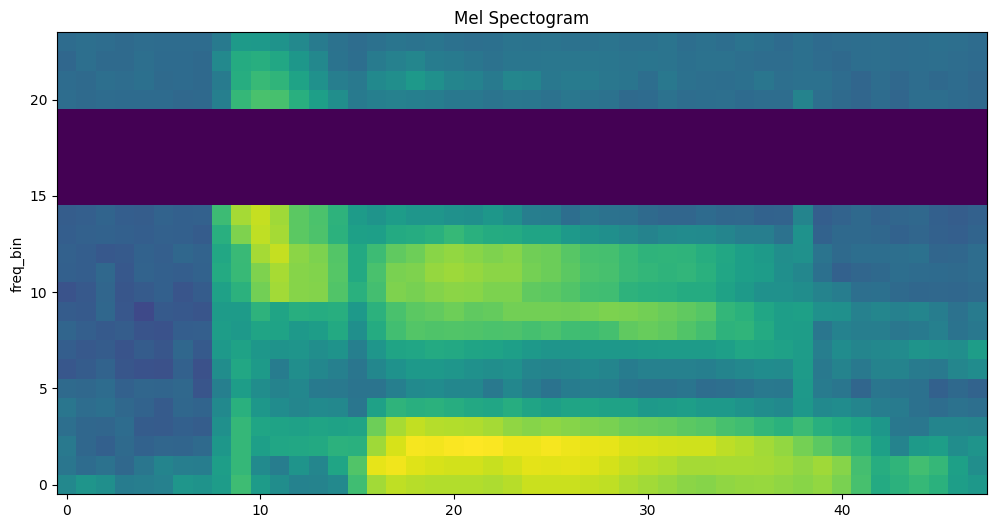

In [18]:
class RawAudioDatasetFreqMasking(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.freq_mask = FrequencyMasking(freq_mask_param=7)

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)
        specgram = self.freq_mask(specgram)

        return specgram, class_label, path_to_audio

    def __len__(self):
        return self.df.shape[0]

ds = RawAudioDatasetFreqMasking(audio_df, transform)
sample_masking = ds[20]
plot_spectogram(sample_masking[0][0], 'Mel Spectogram')
print(f'sample_masking.shape: {sample_masking[0].shape}, sample_masking.class: {sample_masking[1]}')
plt.savefig('sample_masking.png')

In [12]:
def save_processed_dataset(dataset: RawAudioDatasetFreqMasking, output_base_dir: str):
    """
    Processes each item in the dataset and saves the resulting spectrogram tensor
    to files organized by class label and original filename.

    Args:
        dataset: An instance of RawAudioDataset.
        output_base_dir: The base directory where the processed data will be saved.
                         E.g., 'RawFreqMasking'.
    """
    os.makedirs(output_base_dir, exist_ok=True)

    print(f"Saving processed dataset to {os.path.abspath(output_base_dir)}")
    print(f"Total items to process: {len(dataset)}")

    # Iterate through the dataset using tqdm for a progress bar
    # Accessing items via index calls the __getitem__ method
    for i in tqdm(range(len(dataset)), desc="Processing and Saving"):
        item = dataset[i]

        # Check if item is valid (in case of errors handled in __getitem__)
        if item[0] is None:
            continue # Skip this item if there was an error

        specgram, class_label, original_path = item

        # Create the class subdirectory
        # Use str(class_label) to handle potential numeric labels
        class_output_dir = os.path.join(output_base_dir, str(class_label))
        os.makedirs(class_output_dir, exist_ok=True)

        # Generate the output filename based on the original filename
        original_filename = os.path.basename(original_path) # e.g., '0_59_29.wav'
        filename_base, _ = os.path.splitext(original_filename) # e.g., '0_59_29'
        output_filename = f"{filename_base}.pt" # Save as a PyTorch tensor file

        # Create the full path to save the file
        save_path = os.path.join(class_output_dir, output_filename)

        # Save the spectrogram tensor
        try:
            torch.save(specgram, save_path)
        except Exception as e:
             print(f"\nError saving {save_path}: {e}") # Print newline to not mess with tqdm bar


    print("\nDataset saving complete.")

save_processed_dataset(ds, 'RawWithDataAugmentation')

Saving processed dataset to /Users/bitfalt/Developer/IA-Project2/notebooks/RawWithDataAugmentation
Total items to process: 30000


Processing and Saving: 100%|██████████| 30000/30000 [00:47<00:00, 631.59it/s]


Dataset saving complete.


sample_bilateral.shape: torch.Size([1, 24, 48]), sample_bilateral.class: 7


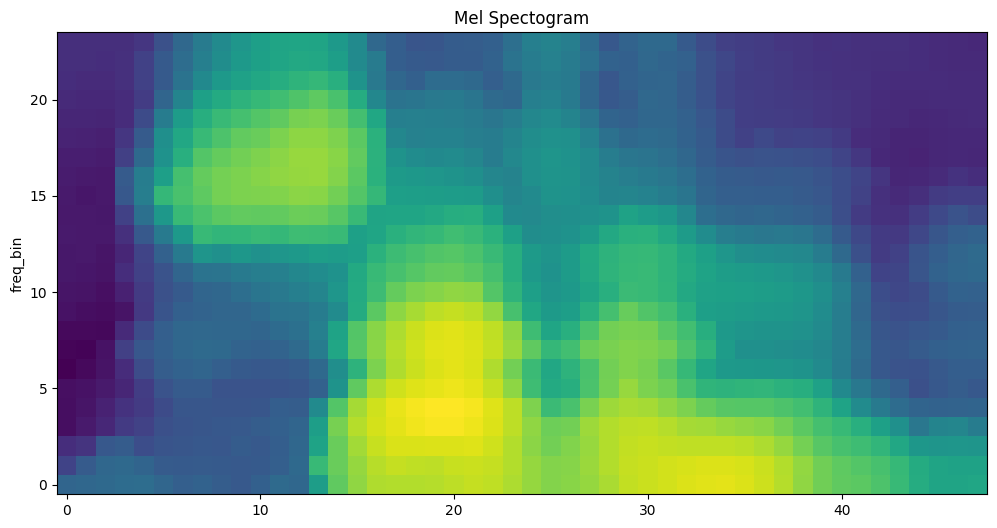

In [13]:
class BilateralAudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.d = 5
        self.sigmaColor = 10
        self.sigmaSpace = 10

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        specgram = self.apply_filter(specgram)

        return specgram, class_label, path_to_audio

    def __len__(self):
        return self.df.shape[0]

    def apply_filter(self, specgram):
        filtered_channels = []
        for channel in range(specgram.shape[0]):
            specgram_channel_np = specgram[channel].numpy()
            filtered_channel_np = cv2.bilateralFilter(
                specgram_channel_np.astype(np.float32),
                self.d,
                self.sigmaColor,
                self.sigmaSpace,
            )
            filtered_channels.append(torch.from_numpy(filtered_channel_np))
            filtered_specgram = torch.stack(filtered_channels)
            
        return filtered_specgram

ds = BilateralAudioDataset(audio_df, transform)
sample_bilateral = ds[0]
plot_spectogram(sample_bilateral[0][0], 'Mel Spectogram')
print(f'sample_bilateral.shape: {sample_bilateral[0].shape}, sample_bilateral.class: {sample_bilateral[1]}')
plt.savefig('sample_bilateral.png')


In [14]:
def save_processed_dataset(dataset: BilateralAudioDataset, output_base_dir: str):
    """
    Processes each item in the dataset and saves the resulting spectrogram tensor
    to files organized by class label and original filename.

    Args:
        dataset: An instance of RawAudioDataset.
        output_base_dir: The base directory where the processed data will be saved.
                         E.g., 'RawFreqMasking'.
    """
    os.makedirs(output_base_dir, exist_ok=True)

    print(f"Saving processed dataset to {os.path.abspath(output_base_dir)}")
    print(f"Total items to process: {len(dataset)}")

    # Iterate through the dataset using tqdm for a progress bar
    # Accessing items via index calls the __getitem__ method
    for i in tqdm(range(len(dataset)), desc="Processing and Saving"):
        item = dataset[i]

        # Check if item is valid (in case of errors handled in __getitem__)
        if item[0] is None:
            continue # Skip this item if there was an error

        specgram, class_label, original_path = item

        # Create the class subdirectory
        # Use str(class_label) to handle potential numeric labels
        class_output_dir = os.path.join(output_base_dir, str(class_label))
        os.makedirs(class_output_dir, exist_ok=True)

        # Generate the output filename based on the original filename
        original_filename = os.path.basename(original_path) # e.g., '0_59_29.wav'
        filename_base, _ = os.path.splitext(original_filename) # e.g., '0_59_29'
        output_filename = f"{filename_base}.pt" # Save as a PyTorch tensor file

        # Create the full path to save the file
        save_path = os.path.join(class_output_dir, output_filename)

        # Save the spectrogram tensor
        try:
            torch.save(specgram, save_path)
        except Exception as e:
             print(f"\nError saving {save_path}: {e}") # Print newline to not mess with tqdm bar


    print("\nDataset saving complete.")

save_processed_dataset(ds, 'BilateralWithoutDataAugmentation')

Saving processed dataset to /Users/bitfalt/Developer/IA-Project2/notebooks/BilateralWithoutDataAugmentation
Total items to process: 30000


Processing and Saving: 100%|██████████| 30000/30000 [00:42<00:00, 703.46it/s]


Dataset saving complete.


sample_bilateral_masking.shape: torch.Size([1, 24, 48]), sample_bilateral_masking.class: 7


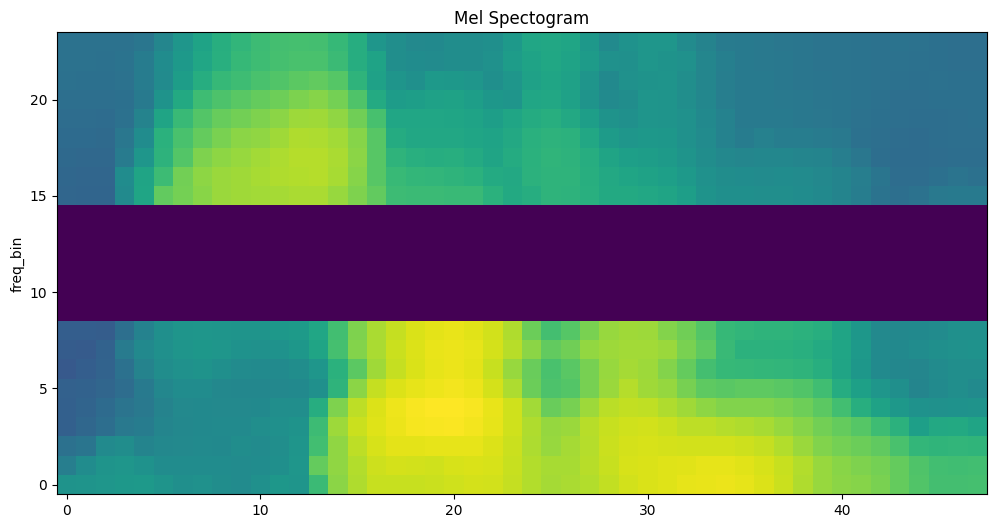

In [15]:
class BilateralAudioDatasetFreqMasking(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.d = 5
        self.sigmaColor = 10
        self.sigmaSpace = 10
        self.freq_mask = FrequencyMasking(freq_mask_param=7)

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)
        specgram = self.apply_filter(specgram)
        specgram = self.freq_mask(specgram)


        return specgram, class_label, path_to_audio

    def __len__(self):
        return self.df.shape[0]

    def apply_filter(self, specgram):
        filtered_channels = []
        for channel in range(specgram.shape[0]):
            specgram_channel_np = specgram[channel].numpy()
            filtered_channel_np = cv2.bilateralFilter(
                specgram_channel_np.astype(np.float32),
                self.d,
                self.sigmaColor,
                self.sigmaSpace,
            )
            filtered_channels.append(torch.from_numpy(filtered_channel_np))
            filtered_specgram = torch.stack(filtered_channels)
            
        return filtered_specgram

ds = BilateralAudioDatasetFreqMasking(audio_df, transform)
sample_bilateral_masking = ds[0]
plot_spectogram(sample_bilateral_masking[0][0], 'Mel Spectogram')
print(f'sample_bilateral_masking.shape: {sample_bilateral_masking[0].shape}, sample_bilateral_masking.class: {sample_bilateral_masking[1]}')
plt.savefig('sample_bilateral_masking.png')


In [16]:
def save_processed_dataset(dataset: BilateralAudioDatasetFreqMasking, output_base_dir: str):
    """
    Processes each item in the dataset and saves the resulting spectrogram tensor
    to files organized by class label and original filename.

    Args:
        dataset: An instance of RawAudioDataset.
        output_base_dir: The base directory where the processed data will be saved.
                         E.g., 'RawFreqMasking'.
    """
    os.makedirs(output_base_dir, exist_ok=True)

    print(f"Saving processed dataset to {os.path.abspath(output_base_dir)}")
    print(f"Total items to process: {len(dataset)}")

    # Iterate through the dataset using tqdm for a progress bar
    # Accessing items via index calls the __getitem__ method
    for i in tqdm(range(len(dataset)), desc="Processing and Saving"):
        item = dataset[i]

        # Check if item is valid (in case of errors handled in __getitem__)
        if item[0] is None:
            continue # Skip this item if there was an error

        specgram, class_label, original_path = item

        # Create the class subdirectory
        # Use str(class_label) to handle potential numeric labels
        class_output_dir = os.path.join(output_base_dir, str(class_label))
        os.makedirs(class_output_dir, exist_ok=True)

        # Generate the output filename based on the original filename
        original_filename = os.path.basename(original_path) # e.g., '0_59_29.wav'
        filename_base, _ = os.path.splitext(original_filename) # e.g., '0_59_29'
        output_filename = f"{filename_base}.pt" # Save as a PyTorch tensor file

        # Create the full path to save the file
        save_path = os.path.join(class_output_dir, output_filename)

        # Save the spectrogram tensor
        try:
            torch.save(specgram, save_path)
        except Exception as e:
             print(f"\nError saving {save_path}: {e}") # Print newline to not mess with tqdm bar


    print("\nDataset saving complete.")

save_processed_dataset(ds, 'BilateralWithDataAugmentation')

Saving processed dataset to /Users/bitfalt/Developer/IA-Project2/notebooks/BilateralWithDataAugmentation
Total items to process: 30000


Processing and Saving: 100%|██████████| 30000/30000 [00:42<00:00, 710.62it/s]


Dataset saving complete.
